In [1]:
#Importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

In [2]:
data= pd.read_csv(r"C:\Users\Public\Documents\SMSSpamCollection1",
                 sep='\t',names=['label','text'])

In [3]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
#Preprocessing and Exploring the Dataset
import nltk

# Downloading the Punkt tokenizer models
nltk.download("punkt")

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vaishnavi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#Building word cloud to see which message is spam and which is not
ham_words = ''
spam_words = ''

In [7]:
#Converting words to vectors
#converting words to vectors using either Count Vectorizer or by using TF-IDF Vectorizer.
#TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus 
#but also provides the importance of the words. removing the words that are less important for analysis, 
#hence making the model building less complex by reducing the input dimensions.

from collections import Counter

total_counts = Counter()

# Loop through each row in the 'text' column
for i in range(len(data)):
    # Split the text into words and count occurrences
    for word in data['text'].values[i].split(" "):
        total_counts[word] += 1

print("Total words in dataset:", len(total_counts))

Total words in dataset: 15693


In [8]:
# Sorting in decreasing order (Word with highest frequency appears first)

vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:60])

['to', 'you', 'I', 'a', 'the', 'and', 'in', 'is', 'i', 'u', 'for', 'my', '', 'of', 'me', 'your', 'on', 'have', '2', 'that', 'it', 'are', 'call', 'or', 'be', 'at', 'with', 'not', 'will', 'get', 'can', 'U', 'ur', 'so', "I'm", 'but', '&lt;#&gt;', 'You', 'from', '4', 'up', 'do', '.', 'if', 'just', 'go', 'when', 'like', 'know', 'this', 'we', 'all', 'out', 'got', 'was', 'come', 'now', '?', 'am', '...']


In [9]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i

In [10]:
# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)

In [11]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

In [12]:
# Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])

word_vectors.shape

(5572, 15693)

In [13]:
#convert the text data into vectors
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 8713)

In [14]:
#features = word_vectors
features = vectors

In [15]:
#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

In [16]:
# Classifying using sklearn's pre-built classifiers
#In this step we will use some of the most popular classifiers out there and compare their results.

#Classifiers used:
#spam classifier using logistic regression
#email spam classification using Support Vector Machine(SVM)
#spam classifier using naive bayes
#spam classifier using decision tree
#spam classifier using K-Nearest Neighbor(KNN)
#spam classifier using Random Forest Classifier

In [17]:
#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [18]:
#initializing multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [19]:
#creating a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [21]:
#fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [22]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [accuracy_score(y_test , pred)]))

In [23]:
 #Predictions using TFIDF Vectorizer algorithm
pred_scores_word_vectors

[('SVC', [0.9844497607655502]),
 ('KN', [0.9557416267942583]),
 ('NB', [0.9868421052631579]),
 ('DT', [0.9665071770334929]),
 ('LR', [0.9617224880382775]),
 ('RF', [0.9760765550239234])]

In [24]:
#Model Predictions
#write functions to detect if the message is spam or not
def find(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [25]:
newtext = ["Free entry"]
integers = vectorizer.transform(newtext)

In [26]:
x = mnb.predict(integers)
find(x)

Message is NOT Spam


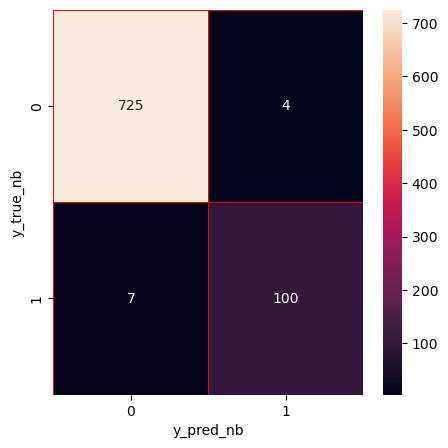

In [27]:
#Checking Classification Results with Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Naive Bayes
y_pred_nb = mnb.predict(X_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_nb")
plt.ylabel("y_true_nb")
plt.show()

In [28]:
from wordcloud import WordCloud

In [29]:
# Initializing variables to store spam and ham words
spam_words = ""
ham_words = ""

# Creating a corpus of spam messages
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        spam_words += word + ' '

# Creating a corpus of ham messages
for val in data[data['label'] == 'ham'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        ham_words += word + ' '

In [30]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

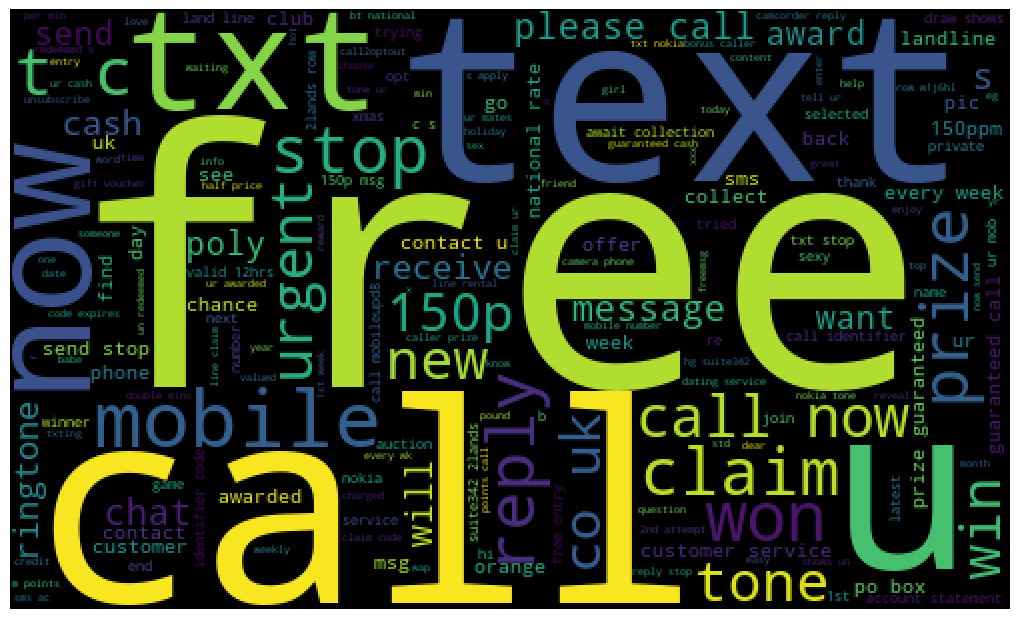

In [31]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

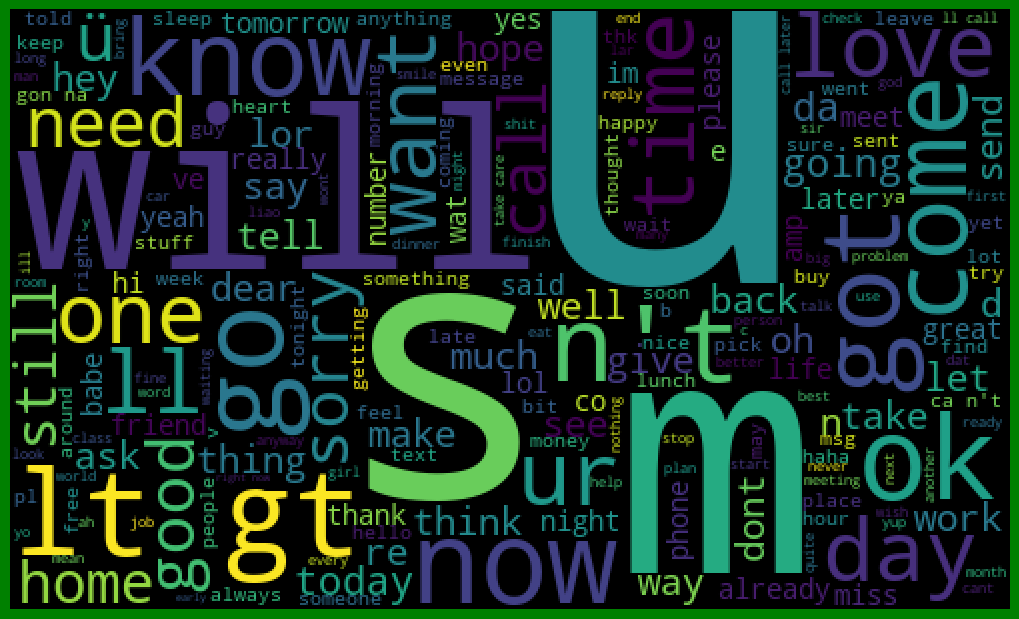

In [32]:
#Creating Ham wordcloud
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [33]:
#from the spam word cloud,"free" is most often used in spam.
#Now, converting the spam and ham into 0 and 1 respectively so that the machine can understand.

data = data.replace(['ham','spam'],[0, 1])
data.head(10)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [34]:
#Removing punctuation and stopwords from the messages
#Punctuation and stop words do not contribute anything to the model, so removing them. Using NLTK library for the ease


import nltk

# Downloading stopwords from NLTK
nltk.download('stopwords')

# Removing punctuations and stopwords
import string
from nltk.corpus import stopwords

def text_process(text):
    # Removing punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Removing stopwords
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

# Applying text processing function to the 'text' column
data['text'] = data['text'].apply(text_process)
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vaishnavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif u oni
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say early hor U c already say
4,0,Nah dont think goes usf lives around though


In [35]:
sent = 'Hello friends! How are you? We will learning python today'

In [36]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.corpus import stopwords
swords = stopwords.words('english')
from nltk.tokenize import word_tokenize
word_tokenize(sent)

['Hello',
 'friends',
 '!',
 'How',
 'are',
 'you',
 '?',
 'We',
 'will',
 'learning',
 'python',
 'today']

In [37]:
def clean_text(sent):
 tokens = word_tokenize(sent)
 clean = [word for word in tokens if word.isdigit() or word.isalpha()]
 clean = [ps.stem(word) for word in clean
 if word not in swords]
 return clean

In [38]:
clean_text(sent)

['hello', 'friend', 'how', 'we', 'learn', 'python', 'today']